# Installing Dependencies

In [ ]:
!pip install -q https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-2.11.0-cp37-cp37m-linux_x86_64.whl


In [ ]:
!pip install -q tensorflow-io

In [ ]:
! pip install -q -U tensorflow-io transformers librosa tensorflow==2.11.0 tf2onnx keras2onnx onnxruntime

In [ ]:
!pip install tensorflow-datasets

# importing Dependencies

In [88]:
#Import necessary libraries 

import warnings
import pandas as pd 
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import librosa
device_name = tf.test.gpu_device_name()
device_name
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import Audio
#import tf2onnx
#import onnx
#import onnxruntime as ort
print ('listo')

listo


# Set up file location

In [89]:
#List the folders found inside of the directory 
for i in os.listdir('/kaggle/input/audio-data/voices_dataset'):
  print(i)

Andres Cabral
David Mayorga
Fernando Meneses


In [56]:
#Define the path to the audio data 
#Loading the segmented 5 second audios from the first model implemented
audio_path = '/kaggle/input/audio-data/voices_dataset'
print('listo')

listo


# Set up Hyper parameters 

Here num_classes are number of speakers. In our case, there´s three

Num_samples = 80000 is sample rate, as audios length are 5s so sample rate for 5s is 80000.

I kept Batch_size is 32, and learning_rate = 0.001

In [57]:
# Defining model and data parameters

num_classes = 3
num_samples = 80000
num_mel_bins = 128
fft_length = 2048
hop_length = 512
batch_size = 32
learning_rate = 0.001
print('listo')

listo


# Make a list data with labels

In [58]:
# Initialize lists to store audio files and their corresponding labels
audio_files = []
labels = []

labelind = -1

# Iterate through labels and audio files to collect data

for label in os.listdir(audio_path):
    labelind +=1
    label_path = os.path.join(audio_path, label)
    for audio_file in os.listdir(label_path):
        audio_file_path = os.path.join(label_path, audio_file)
        audio_files.append(audio_file_path)
        labels.append(labelind)
        
print('listo')

listo


# Preprocess audio file into numeric form

In [59]:
# Define a function to preprocess audio files
def preprocess_audio(audio_file_path):

    audio, sr = librosa.load(audio_file_path, sr=num_samples)
    if len(audio) > num_samples:
        audio = audio[:num_samples]
    else:
        audio = np.pad(audio, (0, num_samples - len(audio)), 'constant')
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=fft_length, hop_length=hop_length, n_mels=num_mel_bins)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    return abs(mel_spec_db)


# Initialize a list to store preprocessed audio data
audio_data = []

# Preprocess audio files and store the data
for audio_file in audio_files:
    mel_spec_db = preprocess_audio(audio_file)
    audio_data.append(mel_spec_db)

    
# Convert audio data and labels to NumPy arrays
audio_data = np.array(audio_data)
labels = np.array(labels)

print('listo')

listo


# Spliting main data into Train and Test data

In [61]:
# Split the data into training and validation sets
num_examples = len(audio_files)
num_train_examples = int(num_examples * 0.8)
num_val_examples = num_examples - num_train_examples

train_indices = np.random.choice(num_examples, num_train_examples, replace=False)
val_indices = np.array(list(set(range(num_examples)) - set(train_indices)))

train_data = audio_data[train_indices]
train_labels = labels[train_indices]

val_data = audio_data[val_indices]
val_labels = labels[val_indices]

print('listo')

listo


In [62]:
# Create TensorFlow datasets for the training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=num_train_examples)
train_dataset =train_dataset.batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_dataset = val_dataset.batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

print('listo')

listo


# Simple Model

In [63]:
# Define a CNN model for audio classification

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 157, 1)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    #Third convolutional block
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    tf.keras.layers.Dropout(0.2),
    
    # Fourth convolutional block
    tf.keras.layers.Conv2D(256, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
        
    
    # Global Average Pooling instead of flattening
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(64, activation='relu'),   
    #tf.keras.layers.Dropout(0.5),
    
    # Output layer for classification
    tf.keras.layers.Dense(11, activation='softmax')
])

print('listo')

listo


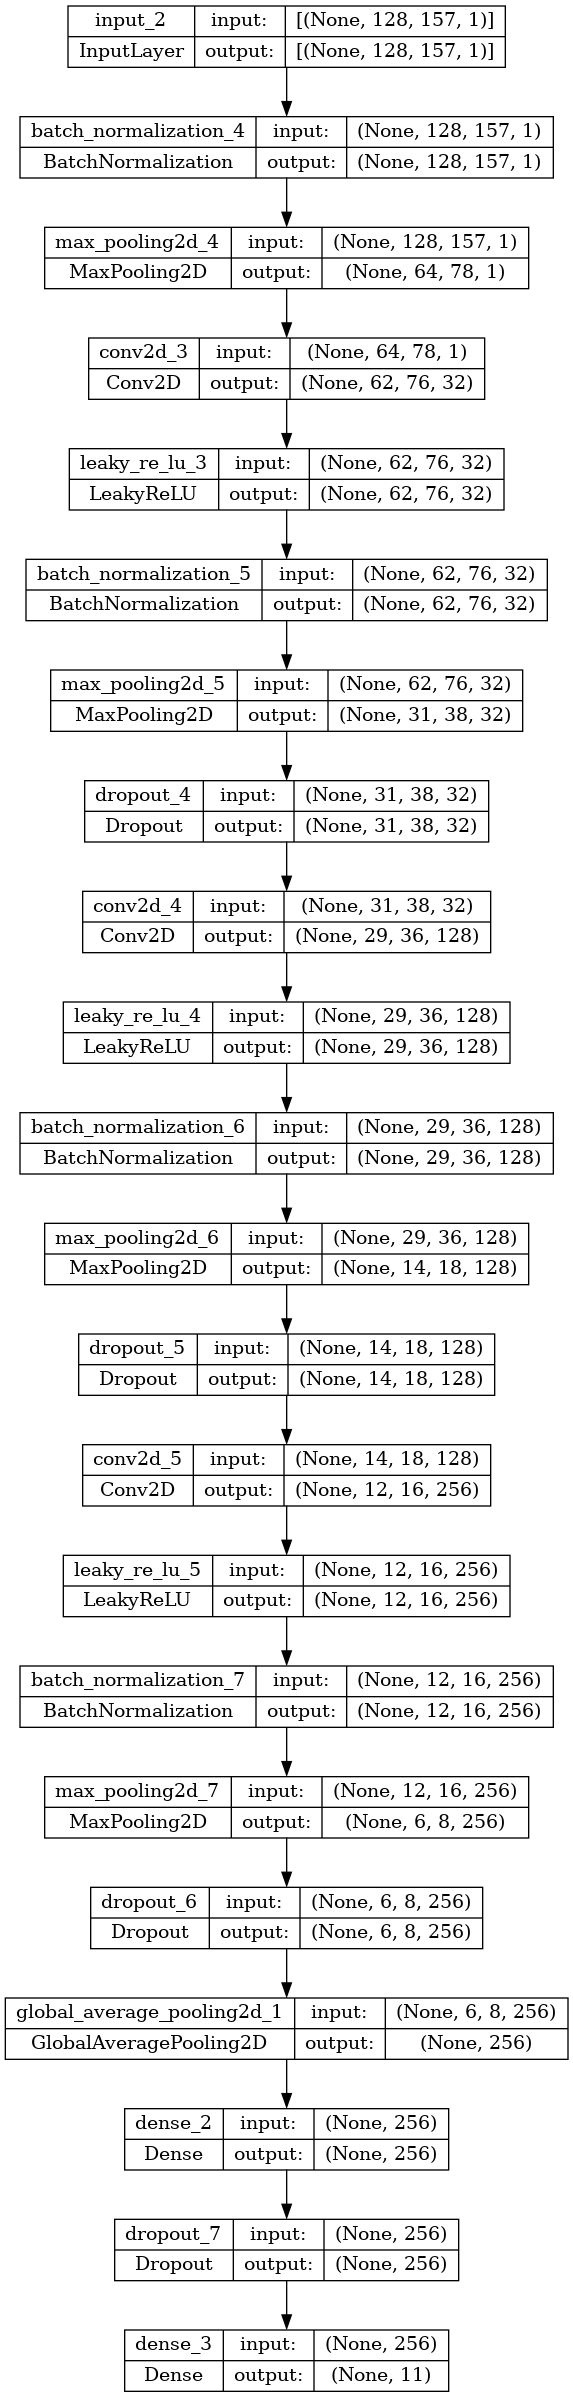

In [64]:
# Import model visualization tools
from keras.utils.vis_utils import plot_model

# Generate a plot of the model architecture
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Creating Callbacks for save the best trained model.

In [65]:
# Define a callback for model training to save the best model
call_back = [tf.keras.callbacks.ModelCheckpoint(filepath='best_model_vgg.h5', 
                                                monitor='val_accuracy',
                                                mode='max',
                                                verbose=1,
                                                save_best_only=True)]

In [66]:
# Compile the model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.SparseCategoricalAccuracy()],
            
)
print('listo')

listo


In [67]:
# Train the model and monitor its performance
# 50 total epocs were inserted for fine tuning 
hist = model2.fit(train_dataset, epochs=50, validation_data=val_dataset,callbacks=call_back,)

Epoch 1/50


2023-11-09 01:54:51.254322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/27 [==========================>...] - ETA: 0s - loss: 1.2862 - accuracy: 0.4750 - sparse_categorical_accuracy: 0.4750
Epoch 1: val_accuracy improved from -inf to 0.36866, saving model to best_model_vgg.h5
27/27 [==============================] - 4s 27ms/step - loss: 1.2648 - accuracy: 0.4803 - sparse_categorical_accuracy: 0.4803 - val_loss: 4.5101 - val_accuracy: 0.3687 - val_sparse_categorical_accuracy: 0.3687
Epoch 2/50
25/27 [==========================>...] - ETA: 0s - loss: 0.6876 - accuracy: 0.7212 - sparse_categorical_accuracy: 0.7212
Epoch 2: val_accuracy improved from 0.36866 to 0.37327, saving model to best_model_vgg.h5
27/27 [==============================] - 0s 17ms/step - loss: 0.6739 - accuracy: 0.7269 - sparse_categorical_accuracy: 0.7269 - val_loss: 1.6835 - val_accuracy: 0.3733 - val_sparse_categorical_accuracy: 0.3733
Epoch 3/50
25/27 [==========================>...] - ETA: 0s - loss: 0.4180 - accuracy: 0.8600 - sparse_categorical_accuracy: 0.8600
Epoch 3: val_accur

dict_keys(['loss', 'accuracy', 'sparse_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_sparse_categorical_accuracy'])


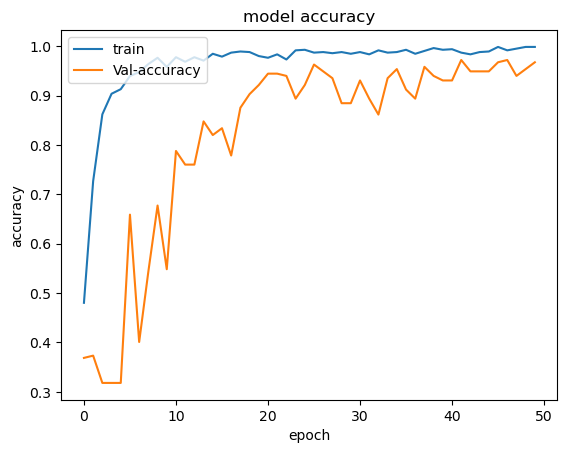

In [68]:
# Print available history keys
print(hist.history.keys())

# Plot the training and validation accuracy
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
# plt.plot(hist.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val-accuracy'], loc='upper left')
plt.show()

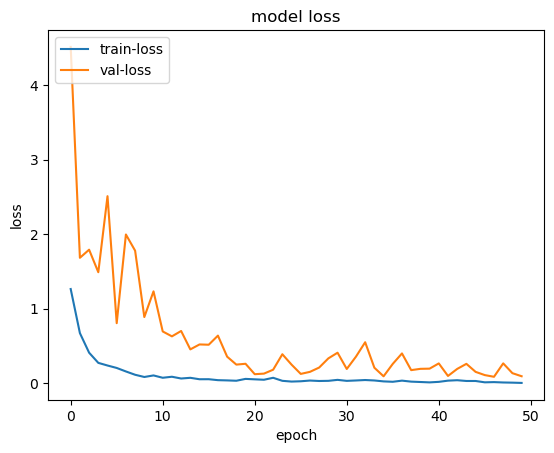

In [69]:
# Plot the training and validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss', 'val-loss'], loc='upper left')
plt.show()

In [70]:
# Perform inference on the validation dataset
features, labels = val_dataset.as_numpy_iterator().next()
features[0]

array([[69.47076 , 80.      , 80.      , ..., 80.      , 80.      ,
        74.76659 ],
       [59.482628, 66.59871 , 77.69273 , ..., 57.393585, 60.4969  ,
        66.939804],
       [51.503017, 47.501484, 56.514267, ..., 47.3764  , 48.711494,
        62.68716 ],
       ...,
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ],
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ],
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ]], dtype=float32)

In [87]:
#Select random audios from the dataset and assign the corresponding label for each 
#0 is Assigned to Andres Cabral
#1 is Assigned to David Mayorga
#2 is Assigned to Fernando Meneses
labels

array([1, 2, 2, 2, 1, 0, 1, 1, 1, 0, 2, 1, 1, 0, 0, 0, 1, 2, 1, 2, 2, 0,
       1, 0, 2, 0, 1, 1, 0, 0, 0, 0])

In [78]:
# Predict the labels for the features
y_pred = model2.predict(features)

1/1 [==============================] - 0s 121ms/step


In [86]:
# Initialize a list for predicted labels
pred = []

[]


In [80]:
# Extract the class with the highest probability as the prediction
for i in y_pred:
    pred.append(i.argmax())

In [81]:
# Print the original and predicted labels
print("Original Labels:", np.array(labels))
print("Predicted Labels:", np.array(pred))


Original Labels: [1 2 2 2 1 0 1 1 1 0 2 1 1 0 0 0 1 2 1 2 2 0 1 0 2 0 1 1 0 0 0 0]
Predicted Labels: [1 2 2 2 1 0 1 1 1 0 2 1 1 0 0 0 1 2 1 2 2 0 1 0 2 0 1 1 0 0 0 0]


In [92]:
labels = labels[:len(pred)]


In [91]:
# Print the original and predicted labels
print(np.array(labels),'\n',np.array(pred))

[1 2 2 2 1 0 1 1 1 0 2 1 1 0 0 0 1 2 1 2 2 0 1 0 2 0 1 1 0 0 0 0] 
 []


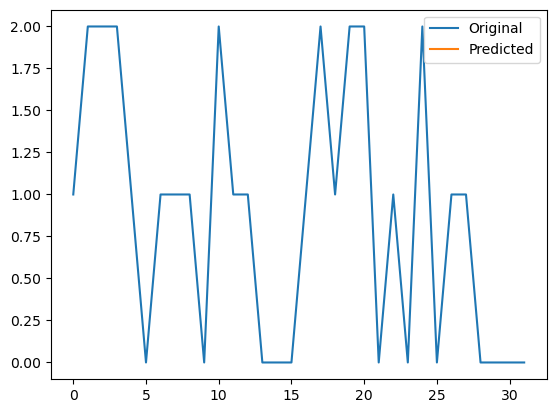

In [90]:
# Plot the original and predicted
plt.plot(np.array(labels),label = 'Original')
plt.plot(np.array(pred), label = 'Predicted')
plt.legend()
plt.show()